<a href="https://colab.research.google.com/github/fentyjames/DualNorm_Unet_Experiment/blob/main/DualNorm_Unet_Experiments_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm #show beautiful progress bar
import matplotlib.pyplot as plt

import os
import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/UNET_ARCHITECTURE')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import requests
from pathlib import Path


if Path("F_UNET_PARTS.py").is_file():
  print("F_UNET_PARTS.py already exists, skipping download")
else:
  print("DownloadingF_UNET_PARTS.py")
  # Get the file and read it
  request = requests.get("/content/drive/MyDrive/UNET_ARCHITECTURE/F_UNET_PARTS.py")
  with open("unet_parts8.py", "wb") as f:
    f.write(request.content)

F_UNET_PARTS.py already exists, skipping download


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes, nonlinear='relu', norm_layer=nn.BatchNorm2d): #norm_layer=nn.InstanceNorm2d norm_layer=nn.BatchNorm2d
        super(ResBlock, self).__init__()
        self.nonlinear_layer = nn.ReLU(inplace=True)
        self.norm_0 = norm_layer(out_channels)
        self.norm_1 = norm_layer(out_channels)
        self.conv_0 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x
        x = self.conv_0(x)
        x = self.nonlinear_layer(x)
        x = self.norm_0(x)
        x = self.conv_1(x)
        x = self.nonlinear_layer(x)
        x = self.norm_1(x)
        x += residual
        return x


class InConv(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes, block=ResBlock, batchsize=4, nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super(InConv, self).__init__()
        self.nonlinear_layer = nn.ReLU(inplace=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            block(out_channels, out_channels, n_classes, norm_layer=norm_layer),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes, block=ResBlock, batchsize=4, nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super(Down, self).__init__()
        self.nonlinear_layer = nn.ReLU(inplace=True)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1)
        )
        self.block = block(out_channels, out_channels, n_classes, norm_layer=norm_layer)

    def forward(self, x):
        x = self.maxpool_conv(x)
        x = self.block(x)
        return x


class Mid(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes, batchsize=4, nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super(Mid, self).__init__()
        self.block = ResBlock(in_channels, out_channels, n_classes, norm_layer=norm_layer)

    def forward(self, x):
        x = self.block(x)
        return x


class TransConv(nn.Module):
    def __init__(self, in_channels, batchsize=4, nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super(TransConv, self).__init__()
        self.nonlinear_layer = nn.ReLU(inplace=True)
        self.up = nn.Sequential(
            norm_layer(in_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, n_classes=2, bilinear=True, block=ResBlock, batchsize=4,
                 nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.nonlinear_layer = nn.ReLU(inplace=True)
        self.up = TransConv(in_channels, batchsize=batchsize, nonlinear=nonlinear, norm_layer=norm_layer)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        self.blockname = block
        self.block = block(out_channels, out_channels, n_classes=n_classes, nonlinear=nonlinear, norm_layer=norm_layer)

    def forward(self, x1, x2, seg=None):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.block(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, batchsize=4, nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super(OutConv, self).__init__()
        self.nonlinear_layer = nn.ReLU(inplace=True)
        self.conv = nn.Sequential(
            norm_layer(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


In [7]:
import torch
import torch.nn as nn
#from F_UNET_PARTS_V1 import ResBlock, InConv, Down, Mid, Up, TransConv, OutConv

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


class DualNorm_Unet(nn.Module):
    def __init__(self, n_channels, n_classes, nonlinear='relu', norm_layer=nn.BatchNorm2d):
        super(DualNorm_Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = InConv(n_channels, 32, n_classes=n_classes, block=ResBlock, nonlinear=nonlinear)
        self.down1 = Down(32, 64, n_classes=n_classes, block=ResBlock, nonlinear=nonlinear)
        self.down2 = Down(64, 128, n_classes=n_classes, block=ResBlock, nonlinear=nonlinear)
        self.down3 = Down(128, 256, n_classes=n_classes, block=ResBlock, nonlinear=nonlinear)
        self.down4 = Down(256, 512, n_classes=n_classes, block=ResBlock, nonlinear=nonlinear)
        self.mid = Mid(512, 512, n_classes=n_classes, nonlinear=nonlinear)
        self.up1 = Up(512, 256, n_classes=n_classes, block=ResBlock, nonlinear=nonlinear)
        self.up2 = Up(256, 128, n_classes=n_classes,  block=ResBlock, nonlinear=nonlinear)
        self.up3 = Up(128, 64, n_classes=n_classes,  block=ResBlock, nonlinear=nonlinear)
        self.up4 = Up(64, 32, n_classes=n_classes,  block=ResBlock, nonlinear=nonlinear)
        self.outc = OutConv(32, n_classes, nonlinear=nonlinear)
        self.outsig = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5_1 = self.down4(x4)
        x = self.mid(x5_1)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = self.outsig(x)
        return x



model_0 = DualNorm_Unet(n_channels=3, n_classes=1, )  # Create an instance of the DualNorm_Unet class dropout_rate=0.0
summary(model_0,
        input_size=[(16, 3, 224, 224)],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DualNorm_Unet (DualNorm_Unet)                 [16, 3, 224, 224]    [16, 1, 224, 224]    --                   True
├─InConv (inc)                                [16, 3, 224, 224]    [16, 32, 224, 224]   --                   True
│    └─Sequential (conv)                      [16, 3, 224, 224]    [16, 32, 224, 224]   --                   True
│    │    └─Conv2d (0)                        [16, 3, 224, 224]    [16, 32, 224, 224]   128                  True
│    │    └─ResBlock (1)                      [16, 32, 224, 224]   [16, 32, 224, 224]   18,624               True
├─Down (down1)                                [16, 32, 224, 224]   [16, 64, 113, 113]   --                   True
│    └─Sequential (maxpool_conv)              [16, 32, 224, 224]   [16, 64, 113, 113]   --                   True
│    │    └─MaxPool2d (0)                     [16, 32, 224, 224]   [16, 32, 112, 11

In [8]:

import numpy as np
from F5_JACCARD import Jaccard
#from F23_DULANORM_UNET_V3 import DualNorm_Unet
from timeit import default_timer as timer



dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#dev = torch.device("cpu")
device = torch.device(dev)

# Start the timer
start_time = timer()

def train_model(n_epochs, trainloss, validationloss, accuracy, model, scheduler, lrFile, training_generator, optim, lim, trainFile, trainaccFile, trainepochFile, validation_generator, valFile, valaccFile, pathm, i, modeltype):
    training_losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        batch_losses = []
        jI = 0
        totalBatches = 0
        scheduler.step()
        print('Epoch:', epoch,'LR:', scheduler.get_last_lr()) # Used .get_last_lr() instead of .get_lr()
        lrFile.write('Epoch:'+' '+str(epoch)+' '+'LR:'+' '+str(scheduler.get_last_lr())+"\n")
        lrFile.write(str(scheduler.state_dict())+"\n")

        mb=0
        for trainim, trainmas in training_generator:
            mb+=1
            optim.zero_grad()
            images=trainim.to(device)
            masks=trainmas.to(device)
            outputs=model(images)

            if trainloss =='BCEWithLogitsLoss':
                loss=nn.BCEWithLogitsLoss() #loss = nn.BCELoss()
                output = loss(outputs, masks)
            output.backward()
            optim.step()

            batch_losses.append(output.item())
            batchLoad = len(masks)*lim*lim
            totalBatches = totalBatches + batchLoad
            if accuracy == 'Jaccard':
                thisJac = Jaccard(torch.reshape(masks,(batchLoad,1)),torch.reshape(outputs,(batchLoad,1)))*batchLoad
                jI = jI+thisJac.data[0]

        training_loss = np.mean(batch_losses)
        training_losses.append(training_loss)
        trainFile.write(str(training_losses[epoch])+"\n")
        trainaccFile.write(str((jI/totalBatches).item())+"\n")
        trainepochFile.write(str(epoch)+"\n")


        # End the timer and print out how long it took
        end_time = timer()
        global total_train_time
        total_train_time = end_time - start_time
        print(f"Total training time: {end_time-start_time:.2f} seconds")
        print("=================================================================================")
        print("Training Jaccard:",(jI/totalBatches).item()," (epoch:",epoch,")","Training Locess: ",(training_losses[epoch]))
        print("---------------------------------------------------------------------------------\n")
        lrFile.write("Training loss:"+str(training_losses[epoch])+"\n")
        lrFile.write("Training accuracy:"+str((jI/totalBatches).item())+"\n")


        torch.save(model.state_dict(), os.path.join(pathm, "iremmodel{}.pt".format(i)))
        #list(model.parameters())
        #print("\n____________________")
        #print(model.state_dict())
        validate(validationloss, accuracy, validation_generator, valFile, valaccFile, lim, lrFile, pathm, i, modeltype)
    torch.save(model.state_dict(), os.path.join(pathm, "Finaliremmodel{}.pt".format(i)))


def validate(validationloss, accuracy, validation_generator, valFile, valaccFile, lim, lrFile, pathm, i, modeltype):
    jI = 0
    totalBatches = 0
    validation_losses = []


    if modeltype=='DualNorm_Unet':
        model = DualNorm_Unet(n_channels=3, n_classes=1).to(device)

    model.load_state_dict(torch.load(os.path.join(pathm, "iremmodel{}.pt".format(i))))
    model.eval()
    with torch.no_grad():
        val_losses = []
        for valim, valmas in validation_generator:
            #model.eval()
            images=valim.to(device)
            masks=valmas.to(device)
            outputs=model(images)
            if validationloss == 'BCEWithLogitsLoss':
                loss=nn.BCEWithLogitsLoss() #loss = nn.BCELoss()
                # Convert the target tensor to a single-channel mask
                #masks = masks[:, 0:1, :, :]

                output = loss(outputs, masks)
            val_losses.append(output.item())
            batchLoad = len(masks)*lim*lim
            totalBatches = totalBatches + batchLoad
            if accuracy == 'Jaccard':
                thisJac = Jaccard(torch.reshape(masks,(batchLoad,1)),torch.reshape(outputs,(batchLoad,1)))*batchLoad
                jI = jI+thisJac.data[0]

    dn=jI/totalBatches
    dni=dn.item()
    validation_loss = np.mean(val_losses)
    validation_losses.append(validation_loss)
    valFile.write(str(validation_losses[0])+"\n")
    valaccFile.write(str(dni)+"\n")
    print("Validation Jaccard:",dni)
    print(f"Validation Jaccard: {dni:.2f}%")
    lrFile.write("Validation loss:"+str(validation_losses[0])+"\n")
    lrFile.write("Validation accuracy:"+str(dni)+"\n")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from F5_JACCARD import Jaccard

from F11_SEGPLOTT import segplot
#from F23_DULANORM_UNET_V1 import DualNorm_Unet



dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device(dev)

def test_model(test_generator, lim, testFile, testaccFile, i, modeltype, pathm, trMeanR, trMeanG, trMeanB):


    if modeltype=='DualNorm_Unet':
      net = DualNorm_Unet(n_channels=3, n_classes=1, norm_layer=nn.BatchNorm2d).to(device)
      #net = DualNorm_Unet(n_channels=3, n_classes=1, norm_layer=nn.InstanceNorm2d).to(device)


    net.load_state_dict(torch.load(os.path.join(pathm, "Finaliremmodel{}.pt".format(i))))

    jI = 0
    totalBatches = 0
    test_losses = []
    net.eval()
    with torch.no_grad():
        t_losses = []
        t=0
        for testim, testmas in test_generator:
            images=testim.to(device)
            masks=testmas.to(device)
            outputs = net(images)
            if t==0:
                fig=plt.figure()
                axes=[]
                fimage=images[0].permute(1, 2, 0)
                fimage[:,:,0]=(images[0][0,:,:])
                fimage[:,:,1]=(images[0][1,:,:])
                fimage[:,:,2]=(images[0][2,:,:])
                fimage=fimage.cpu().numpy()
                axes.append(fig.add_subplot(1, 2, 1))
                foutput=outputs[0].permute(1, 2, 0)
                foutput=foutput.cpu().numpy()

                print("=================================================================================\n\n")
                plt.imshow(np.squeeze(foutput, axis=2),  cmap='gray')
                subplot_title=("Test Predicted Mask")
                axes[-1].set_title(subplot_title)
                axes.append(fig.add_subplot(1, 2, 2))
                fmask=masks[0].permute(1, 2, 0)
                fmask=fmask.cpu().numpy()
                plt.imshow(np.squeeze(fmask, axis=2),  cmap='gray')


                plt.imshow(fmask, cmap='gray')

                subplot_title=("Ground Truth Mask")
                axes[-1].set_title(subplot_title)
                n_curve = 'mask_comparison.png'
                plt.savefig(os.path.join(pathm, n_curve))
                plt.show()
                segplot(pathm, lim, fimage, foutput, fmask,  trMeanR, trMeanG, trMeanB)
            losst=nn.BCEWithLogitsLoss()  #losst = nn.BCELoss()


            output = losst(outputs, masks)
            t_losses.append(output.item())
            batchLoad = len(masks)*lim*lim
            totalBatches = totalBatches + batchLoad
            thisJac = Jaccard(torch.reshape(masks,(batchLoad,1)),torch.reshape(outputs,(batchLoad,1)))*batchLoad
            jI = jI+thisJac.data[0]
            #jI = jI+thisJac.item()
            t +=1

    dn=jI/totalBatches
    dni=dn.item()
    test_loss = np.mean(t_losses)
    test_losses.append(test_loss)
    testFile.write(str(test_losses[0])+"\n")
    testaccFile.write(str(dni)+"\n")
    print("======================================TEST JACCARD===============================")
    print("Test Jaccard:",dni)
    print(f"Test Jaccard: {dni:.2f}% | Test losses: {test_loss:.2f}% ")
    print("---------------------------------------------------------------------------------")

Tesla T4
Original image size: (1778, 224, 224, 3) Original target mask size: (1778, 224, 224)

Reshaped image size: (1778, 3, 224, 224) Reshaped mask size: (1778, 1, 224, 224)


image size torch.Size([1778, 3, 224, 224]) mask size torch.Size([1778, 1, 224, 224])
type image <class 'torch.Tensor'> type mask <class 'torch.Tensor'>


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 LR: [0.001]
Total training time: 252.17 seconds
Training Jaccard: 0.6448400020599365  (epoch: 0 ) Training Locess:  0.4336645983551678
---------------------------------------------------------------------------------

Validation Jaccard: 0.7734514474868774
Validation Jaccard: 0.77%
Epoch: 1 LR: [0.001]
Total training time: 283.38 seconds
Training Jaccard: 0.8476771116256714  (epoch: 1 ) Training Locess:  0.37092055615625885
---------------------------------------------------------------------------------

Validation Jaccard: 0.9005300402641296
Validation Jaccard: 0.90%
Epoch: 2 LR: [0.001]
Total training time: 314.68 seconds
Training Jaccard: 0.9191002249717712  (epoch: 2 ) Training Locess:  0.35067119567017807
---------------------------------------------------------------------------------

Validation Jaccard: 0.9404479265213013
Validation Jaccard: 0.94%
Epoch: 3 LR: [0.001]
Total training time: 346.60 seconds
Training Jaccard: 0.944932222366333  (epoch: 3 ) Training Locess:

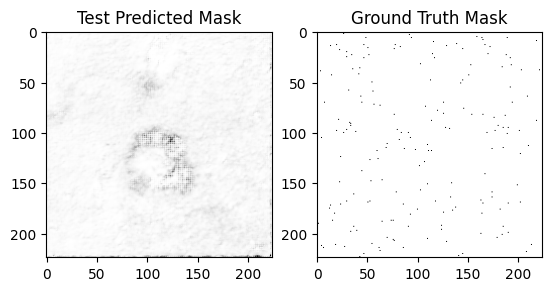



image shape (224, 224, 3) output shape (224, 224, 1) groundtruth shape (224, 224, 1)
1.0
======================================TEST JACCARD===============================
Test Jaccard: 0.9956780672073364
Test Jaccard: 1.00% | Test losses: 0.32% 
---------------------------------------------------------------------------------
============================LARNING CURVES=======================================



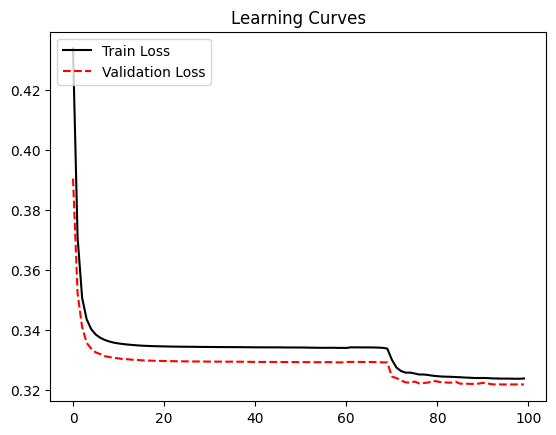




==========================ACCURACY CURVES=======================================



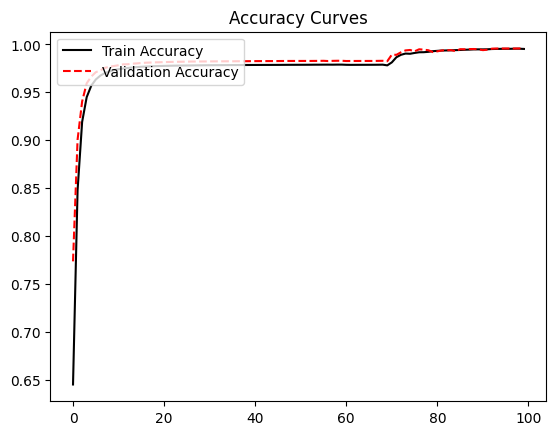




Device: cuda
Memory allocated before model: 334054912
Memory allocated after model: 334054912
Memory allocated before model: 334054912
Original image size: (1778, 224, 224, 3) Original target mask size: (1778, 224, 224)

Reshaped image size: (1778, 3, 224, 224) Reshaped mask size: (1778, 1, 224, 224)


image size torch.Size([1778, 3, 224, 224]) mask size torch.Size([1778, 1, 224, 224])
type image <class 'torch.Tensor'> type mask <class 'torch.Tensor'>


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 LR: [0.0001]
Total training time: 3536.25 seconds
Training Jaccard: 0.613178551197052  (epoch: 0 ) Training Locess:  0.4445112229962098
---------------------------------------------------------------------------------

Validation Jaccard: 0.6442838311195374
Validation Jaccard: 0.64%
Epoch: 1 LR: [0.0001]
Total training time: 3569.09 seconds
Training Jaccard: 0.6473636627197266  (epoch: 1 ) Training Locess:  0.43319106219630493
---------------------------------------------------------------------------------

Validation Jaccard: 0.6742050647735596
Validation Jaccard: 0.67%
Epoch: 2 LR: [0.0001]
Total training time: 3601.60 seconds
Training Jaccard: 0.68536376953125  (epoch: 2 ) Training Locess:  0.42138882608790146
---------------------------------------------------------------------------------

Validation Jaccard: 0.7220686078071594
Validation Jaccard: 0.72%
Epoch: 3 LR: [0.0001]
Total training time: 3634.29 seconds
Training Jaccard: 0.7251981496810913  (epoch: 3 ) Training L

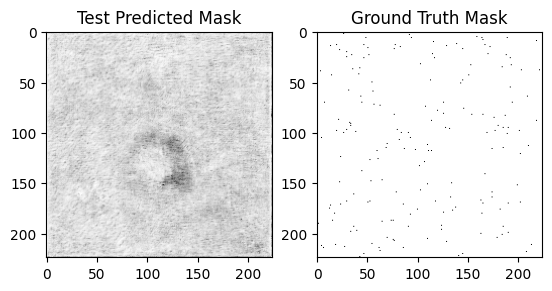



image shape (224, 224, 3) output shape (224, 224, 1) groundtruth shape (224, 224, 1)
1.0
======================================TEST JACCARD===============================
Test Jaccard: 0.9928866624832153
Test Jaccard: 0.99% | Test losses: 0.33% 
---------------------------------------------------------------------------------
============================LARNING CURVES=======================================



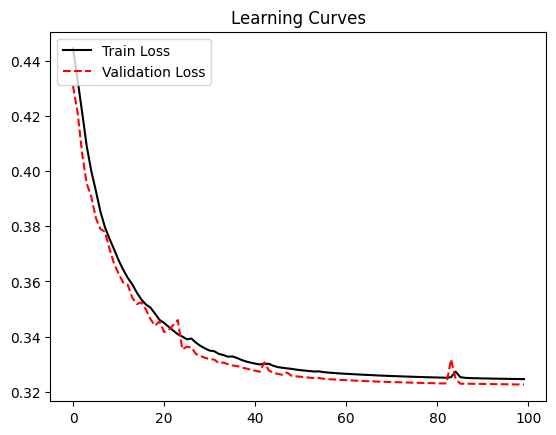




==========================ACCURACY CURVES=======================================



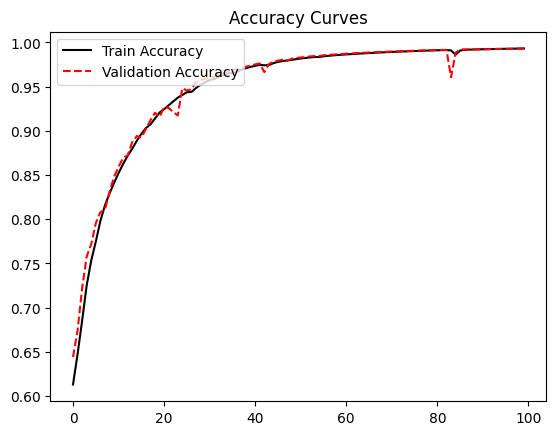




Device: cuda
Memory allocated before model: 334842368
Memory allocated after model: 334842368
Memory allocated before model: 334842368


In [10]:
from __future__ import print_function
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#import numpy as np
import datetime
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from F3_DATASET import satellitedata
#from F4_TRAIN import train_model
from F6_CROSSVAL import CrossVal
#from F7_TEST import test_model
#from F7_TEST2 import test_model
from F8_IMAGES import get_images
#from F23_DULANORM_UNET import DualNorm_Unet
#from F23_DULANORM_UNET_V1 import DualNorm_Unet
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



##############################################################################
if __name__ == '__main__':

    if (torch.cuda.is_available()):
        print(torch.cuda.get_device_name(0))

    bg=datetime.datetime.now()
    bgh=bg.hour
    bgm=bg.minute


    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Uncommented the cpu device
    #dev = torch.device("cpu")
    device = torch.device(dev)

    for i in range(0,2):
        data_folder = os.path.join("/content/drive/MyDrive/UNET_ARCHITECTURE/experiments")
        file_to_open = os.path.join(data_folder, "model{}.txt".format(i))
        with open(file_to_open) as f:
            #lines = f.readlines()
            lines = [line.rstrip() for line in f]
        trainSetSize=int(lines[0])
        fno = int(lines[1])
        fsiz = int(lines[2])
        valRatio = float(lines[3])
        miniBatchSize = int(lines[4])
        n_epochs = int(lines[5])
        learnRate = float(lines[6])
        optimizerType=str(lines[7])
        trainloss=str(lines[8])
        validationloss=str(lines[9])
        accuracy=str(lines[10])
        initialization=str(lines[11])
        step_size=int(lines[12])
        gamma=float(lines[13])
        lim=int(lines[14])
        modeltype=str(lines[15])
        chindex=str(lines[16])
        transfertype=str(lines[17])

        tsind, trind,vlind = CrossVal(trainSetSize,fno,fsiz)
        input_images, target_masks, trMeanR, trMeanG, trMeanB = get_images(trainSetSize, fno, fsiz, tsind, trind, vlind, chindex)

        params = {'batch_size': miniBatchSize, 'shuffle': False}

        training_set = satellitedata(input_images[trind], target_masks[trind])
        training_generator = DataLoader(training_set, **params)

        validation_set = satellitedata(input_images[vlind], target_masks[vlind])
        validation_generator = DataLoader(validation_set, **params)

        test_set = satellitedata(input_images[tsind], target_masks[tsind])
        test_generator = DataLoader(test_set, **params)


        if modeltype=='DualNorm_Unet':
            model = DualNorm_Unet(n_channels=3, n_classes=1, norm_layer=nn.BatchNorm2d).to(device)
            #model = DualNorm_Unet(n_channels=3, n_classes=1, norm_layer=nn.InstanceNorm2d).to(device)


###############################################################################
        def init_weights(m):
            if initialization == 'xavier_uniform_':
                if isinstance(m, nn.Conv2d):
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)

            if initialization == 'xavier_normal_':
                if isinstance(m, nn.Conv2d):
                    torch.nn.init.xavier_normal_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)

            if initialization == 'kaiming_uniform_':
                if isinstance(m, nn.Conv2d):
                    torch.nn.init.kaiming_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)

            if initialization == 'kaiming_normal_':
                if isinstance(m, nn.Conv2d):
                    torch.nn.init.kaiming_normal_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)
###############################################################################
        #model.apply(init_weights)

        if transfertype=='yestr':
            model.load_state_dict(torch.load(os.path.join(data_folder, "2022_8_15_11_11.pt")))
        elif transfertype=='notr':
            model.apply(init_weights)

        if optimizerType =='Adam':
            optim = torch.optim.Adam(model.parameters(),learnRate)
        elif optimizerType =='SGD':
            optim = torch.optim.SGD(model.parameters(),learnRate)
        elif optimizerType =='AdamW':
            optim = torch.optim.AdamW(model.parameters(),learnRate)

        scheduler = StepLR(optim, step_size, gamma)

        d=datetime.datetime.now()
        pathm = os.path.join(data_folder, "{}_{}_{}_{}_{}_model{}".format(d.year, d.month, d.day, d.hour, d.minute, i))
        os.mkdir(pathm)

        os.path.join(pathm, "lrFile.txt")
        lrFile = open("lrFile.txt","w")
        os.path.join(pathm, "trainaccFile.txt")
        trainaccFile = open("trainaccFile.txt","w")
        os.path.join(pathm, "valaccFile.txt")
        valaccFile = open("valaccFile.txt","w")
        os.path.join(pathm, "trainepochFile.txt")
        trainepochFile = open("trainepochFile.txt","w")
        os.path.join(pathm, "trainFile.txt")
        trainFile = open("trainFile.txt","w")
        os.path.join(pathm, "valFile.txt")
        valFile = open("valFile.txt","w")
        train_model(n_epochs, trainloss, validationloss, accuracy, model, scheduler, lrFile, training_generator, optim, lim, trainFile, trainaccFile, trainepochFile, validation_generator, valFile, valaccFile, pathm, i, modeltype)
        trainFile.close()
        valFile.close()
        trainaccFile.close()
        valaccFile.close()
        trainepochFile.close()
        lrFile.close()


        os.path.join(pathm, "testaccFile.txt")
        testaccFile = open("testaccFile.txt","w")
        os.path.join(pathm, "testFile.txt")
        testFile = open("testFile.txt","w")
        test_model(test_generator, lim, testFile, testaccFile, i, modeltype, pathm, trMeanR, trMeanG, trMeanB)
        testFile.close()
        testaccFile.close()

        x=[]
        with open("trainFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                x.append(float(l))

        y=[]
        with open("valFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                y.append(float(l))

        tt=[]
        with open("testFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                tt.append(float(l))

        z=[]
        with open("lrFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                z.append(l)

        xx=[]
        with open("trainaccFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                xx.append(float(l))

        yy=[]
        with open("valaccFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                yy.append(float(l))

        ta=[]
        with open("testaccFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                ta.append(float(l))

        e1=[]
        with open("trainepochFile.txt") as f:
            lines = f.readlines()
            for l in lines:
                e1.append(float(l))


        def logfile():
            global total_train_time
            a=datetime.datetime.now()
            myfile=os.path.join(pathm, "{}_{}_{}_{}_{}.txt".format(a.year, a.month, a.day, a.hour, a.minute))
            LogFile = open(myfile,"w")
            LogFile.write("Date:"+str(datetime.date.today())+"\n")
            LogFile.write("Ending Time:"+str(a.hour)+":"+str(a.minute)+"\n")
            LogFile.write("Starting Time:"+str(bgh)+":"+str(bgm)+"\n")
            LogFile.write("Total Training Time in seconds: "+str(total_train_time)+"\n")
            LogFile.write("Data set size:"+str(trainSetSize)+"\n")
            LogFile.write("Fold number:"+str(fno)+"\n")
            LogFile.write("Fold number:"+str(fsiz)+"\n")
            LogFile.write("Number of validation images:"+str(len(vlind))+"\n")
            LogFile.write("Number of training images:"+str(len(trind))+"\n")
            LogFile.write("Mini batch size:"+str(miniBatchSize)+"\n")
            LogFile.write("Type of initialization:"+initialization+"\n")
            LogFile.write("Test accuracy:"+str(ta)+"\n")
            LogFile.write("Learning rate:"+str(learnRate)+"\n")
            LogFile.write("Model version:"+str(modeltype)+"\n")
            LogFile.write("Optimizer type:"+optimizerType+"\n")
            LogFile.write("Total number of epochs:"+str(n_epochs)+"\n")
            LogFile.write("Training loss function:"+str(trainloss)+"\n")
            LogFile.write("Validation loss function:"+str(validationloss)+"\n")
            LogFile.write("Accuracy function:"+str(accuracy)+"\n")
            LogFile.write("Channel index:"+str(chindex)+"\n")
            LogFile.write("Transfer:"+str(transfertype)+"\n")
            LogFile.write("Model Summary:"+"\n"+str(model)+"\n")
            for i in range(len(z)):
                LogFile.write(str(z[i]))
            LogFile.close()

        logfile()


        print("============================LARNING CURVES=======================================\n")

        plt.plot(x,"k-", label="Train Loss")
        plt.plot(y,"r--", label="Validation Loss")
        plt.title('Learning Curves')
        plt.legend(loc="upper left")
        l_curve = 'learning_curves.png'
        plt.savefig(os.path.join(pathm, l_curve))
        plt.show()
        print("\n\n")

        print("==========================ACCURACY CURVES=======================================\n")

        plt.plot(xx, "k-", label="Train Accuracy")
        plt.plot(yy, "r--", label="Validation Accuracy")
        plt.title('Accuracy Curves')
        plt.legend(loc="upper left")
        a_curve = 'accuracy_curves.png'
        plt.savefig(os.path.join(pathm, a_curve))
        plt.show()

        print("\n\n")
        # print("Memory allocated before model {}".format(i),torch.cuda.memory_allocated(device=torch.device('cpu')))
        # #del model
        # #torch.cuda.empty_cache()
        # print("Memory allocated after model {}".format(i),torch.cuda.memory_allocated(device=torch.device('cpu')))

        # print("Memory allocated before model {}".format(i),torch.cuda.memory_allocated())
        # # del model
        # # torch.cuda.empty_cache()
        # # print("Memory allocated after model {}".format(i),torch.cuda.memory_allocated())

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device:", device)

        print("Memory allocated before model:", torch.cuda.memory_allocated(device=device))
        # del model
        # torch.cuda.empty_cache()
        print("Memory allocated after model:", torch.cuda.memory_allocated(device=device))

        print("Memory allocated before model:", torch.cuda.memory_allocated())

